# Imports

In [1]:
from pandas import DataFrame
import matplotlib.pyplot as plt
import random
import tensorflow as tf

2024-03-04 20:19:30.406265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 20:19:30.406363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 20:19:30.556072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
relative_dataset_path = '/kaggle/input/'

In [3]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 3.0.5


# Utilities

In [4]:
from pickle import load

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = load(fo, encoding='latin1')
    return dict

In [5]:
def print_red(skk): print("\033[91m {}\033[00m" .format(skk))
def print_green(skk): print("\033[92m {}\033[00m" .format(skk))
def print_yellow(skk): print("\033[93m {}\033[00m" .format(skk))
def print_purple(skk): print("\033[95m {}\033[00m" .format(skk))
def print_cyan(skk): print("\033[96m {}\033[00m" .format(skk))

In [6]:
def read_data(filename):
    print_yellow(f"Reading from {relative_dataset_path}{filename}")
    data = unpickle(f"{relative_dataset_path}{filename}")
    df = DataFrame(list(data.items()), columns=["Keys", "Values"])
    return data, df

In [7]:
import time

def display_current_time():
    current_time = time.strftime("%d-%m-%Y %H:%M:%S", time.localtime())
    print_yellow(f"Time is {current_time}")

In [8]:
def plot_metrics(title, xlabel, ylabel, history, metric1, metric2):
    plt.plot(history.history[metric1], label=metric1)
    plt.plot(history.history[metric2], label=metric2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

def plot_accuracy_validation_precision(history):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plot_metrics('Training and Validation Accuracy', 'Epoch', 'Accuracy', history, 'accuracy', 'val_accuracy')

    plt.subplot(2, 2, 2)
    plot_metrics('Training and Validation Loss', 'Epoch', 'Loss', history, 'loss', 'val_loss')

    plt.subplot(2, 2, 3)
    plot_metrics('Training and Validation Precision', 'Epoch', 'Precision', history, 'precision', 'val_precision')

    plt.tight_layout()
    plt.show()

In [9]:
def display_model_hyperparameters(total_epochs, lr, activation):
    print_cyan(f"Total Epochs: {total_epochs}")
    print_cyan(f"Learning Rate: {lr}")
    print_cyan(f"Activation: {activation}")

In [10]:
from sklearn.metrics import accuracy_score

def display_model_stats(history_param, X_test, y_test, model):
    
    results = model.predict(X_test)
    preds_cls_idx = results.argmax(axis=-1)
    test_accuracy = accuracy_score(y_test, preds_cls_idx)
    
    train_acc = history_param.history['accuracy'][-1] * 100
    val_acc = history_param.history['val_accuracy'][-1] * 100
    
    print_green(f"Training accuracy: {train_acc : .2f}%")
    print_green(f"Validation accuracy: {val_acc : .2f}%")
    print_green(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    print_red(f"Training loss: {history_param.history['loss'][-1] : .3f}")
    print_red(f"Validation loss: {history_param.history['val_loss'][-1] : .3f}")
    
    return int(train_acc), int(val_acc), int(test_accuracy * 100)
    

In [11]:
def save_model(train_acc, val_acc, test_acc, accuracy_threshold, model):
    model_name = ""
    if (train_acc and val_acc and test_acc ) > int(accuracy_threshold):
        print_yellow("Saving model....")
        model_name = f"model-{train_acc}-{val_acc}-{test_acc}-sgd.h5"
        model.save(model_name)
        print_yellow(f"Model Saved With Name {model_name}!!")
    else:
        print_red("Didnt save model because accuracy was lesser than 80 !")
    
    return model_name

In [12]:
from keras.callbacks import Callback

class AccuracyPrintingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        
        if val_acc is not None:
            if val_acc >= 0.90:
                print_cyan(f"\nEpoch {epoch + 1}:\n Val Acc: {val_acc}\n")
            elif val_acc >= 0.85:
                print_yellow(f"\nEpoch {epoch + 1}:\n Val Acc: {val_acc}\n")
            elif val_acc >= 0.75:
                print_purple(f"\nEpoch {epoch + 1}:\n Val Acc: {val_acc}\n")
            else:
                print_red(f"\nEpoch {epoch + 1}:\n Val Acc: {val_acc}\n")


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(labels_names,  y_test_param, y_pred):

    conf_mat = confusion_matrix(y_test_param, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True,  xticklabels=labels_names, yticklabels = labels_names)


# Data

#### Reading Labels

In [14]:
labels_data, labels_df = read_data("batches.meta")
labels_df

 Reading from /kaggle/input/batches.meta


,Keys,Values
0,num_cases_per_batch,10000
1,label_names,"[airplane, automobile, bird, cat, deer, dog, f..."
2,num_vis,3072


In [15]:
labels = labels_data["label_names"]
all_labels_df = DataFrame(labels, columns=["Labels"])
label_names_list = all_labels_df["Labels"]
all_labels_df

,Labels
0,airplane
1,automobile
2,bird
3,cat
4,deer
5,dog
6,frog
7,horse
8,ship
9,truck


#### Reading Data

In [16]:
import numpy as np

# Assuming your data looks like this (adjust accordingly)
data1, df1 = read_data("data_batch_1")
data2, df2 = read_data("data_batch_2")
data3, df3 = read_data("data_batch_3")
data4, df4 = read_data("data_batch_4")
data5, df5 = read_data("data_batch_5")

test_data, test_df = read_data("test_batch")

# Combine data
dataset = np.concatenate([data1["data"], data2["data"], data3["data"], data4["data"], data5["data"]], axis=0)
dataset_labels = np.concatenate([data1["labels"], data2["labels"], data3["labels"], data4["labels"], data5["labels"]], axis=0)

print("Combined Data Shape:", dataset.shape)
print("Combined Labels Length:", len(dataset_labels))

test_dataset = test_data["data"]
test_dataset_labels = test_data["labels"]

print("Test Data Shape: ", test_dataset.shape)
print("Test Data Labels Length: ", len(test_dataset_labels))




 Reading from /kaggle/input/data_batch_1
 Reading from /kaggle/input/data_batch_2
 Reading from /kaggle/input/data_batch_3
 Reading from /kaggle/input/data_batch_4
 Reading from /kaggle/input/data_batch_5
 Reading from /kaggle/input/test_batch
Combined Data Shape: (50000, 3072)
Combined Labels Length: 50000
Test Data Shape:  (10000, 3072)
Test Data Labels Length:  10000


In [17]:
# reshape images while taking channel first then rearrange to height, width, channel
dataset = dataset.reshape(len(dataset),3,32,32).transpose(0,2,3,1)
print(dataset.shape)

test_dataset = test_dataset.reshape(len(test_dataset),3,32,32).transpose(0,2,3,1)
print(test_dataset.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [18]:
def display_dataset_images(temp_data, temp_labels,images_per_label=10 ):
    unique_image_labels = set(temp_labels)

    for current_label in unique_image_labels:
        # get indices of images with current label
        current_label_indices = [current_image_index for current_image_index, current_image_label in enumerate(temp_labels) if current_image_label == current_label]

        current_label_random_indices = random.sample(current_label_indices, images_per_label)

        fig, axes = plt.subplots(1, images_per_label, figsize=(12, 1.5))
        fig.suptitle(f"Label: {labels[current_label]}")

        for i, index in enumerate(current_label_random_indices):
            axes[i].imshow(temp_data[index])
            axes[i].axis('off')

        plt.show()

In [19]:
# display_dataset_images(dataset, dataset_labels)

# Data Preprocessing

#### Normalization

In [20]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train_normalized = dataset / 255.0
X_test_normalized = test_dataset / 255.0

y_train = to_categorical(dataset_labels)
y_test = test_dataset_labels

X_train_normalized = np.array(X_train_normalized)
X_test_normalized = np.array(X_test_normalized)

# create validation set
X_train_normalized, X_validation, y_train, y_validation = train_test_split(X_train_normalized, y_train, test_size=0.2, random_state=42)

# print shapes
print("X_train_normalized shape:", X_train_normalized.shape)
print("X_test_normalized shape:", X_test_normalized.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", len(y_test))
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)


X_train_normalized shape: (40000, 32, 32, 3)
X_test_normalized shape: (10000, 32, 32, 3)
y_train shape: (40000, 10)
y_test shape: 10000
X_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000, 10)


#### Data Augmentation

In [21]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train_normalized)

#### Images Data After Normalization

In [22]:
# display_dataset_images(X_train_normalized, y_train)

# Model Building

#### Model Structure

In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from keras.regularizers import l2
from keras import optimizers
from keras.metrics import TopKCategoricalAccuracy, Precision, Recall, AUC

def get_cnn_model(activation = "relu"):
    model = Sequential()
    model.add(Conv2D(96, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())

    model.add(Conv2D(96, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(96, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(192, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation=activation, kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    model.add(Dense(128, activation=activation, kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    return model


#### Model Compilation

In [24]:
def compile_model(lr_param, momentum_param, activation = "relu"):
    model = get_cnn_model(activation)
    print_yellow(f"Compiling model with lr:{lr_param}, momentum:{momentum_param} and activation:{activation}")
    metrics = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        TopKCategoricalAccuracy(k=5, name='top5_accuracy'),
    ]

    optimizer = optimizers.SGD(learning_rate=lr_param, momentum = momentum_param, nesterov = True)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
#     model.summary()
    
    return model

# Model Training

In [25]:
def train_model(model, total_epochs_param, callbacks_param, X_train_param, y_train_param, X_val_param, y_val_param):
    
    start_time = time.time()
    
    display_current_time()

    history = model.fit(
        datagen.flow(X_train_param, y_train_param),
        validation_data=(X_val_param, y_val_param),
        epochs = total_epochs_param,
        callbacks = callbacks_param
    )
    
    display_current_time()
    
    end_time = time.time()
    time_taken = (round(end_time - start_time, 2) / 60 )
    print_yellow(f"Total time taken for training: {time_taken} mins")
    
    return history

#### Hyperparameter Tuning

In [26]:
from itertools import product

best_params = None
best_val_loss = float('inf')

hyperparameter_combinations = {
    'lr': [0.01, 0.001],
    'activation' : ["relu", "tanh"]
}

momentum_value = 0.9
i = 0

for hyperparams in product(*hyperparameter_combinations.values()):
    print_cyan("="*30)
    print_purple(f"Combination Number {i}")
    i+=1
    print_cyan("="*30)
    
    lr, activation = hyperparams
    
    total_epochs = 50
    patience_epochs = 10
    
    display_model_hyperparameters(total_epochs, lr, activation)
    
    model_tuned = compile_model(lr, momentum_value, activation)
    
    history_tuned = train_model(
        model_tuned,
        total_epochs,
        [],
        X_train_normalized,
        y_train,
        X_validation,
        y_validation
    )
    
    val_loss = history_tuned.history['val_loss'][-1]
    val_acc = history_tuned.history['val_accuracy'][-1]
    
    # Check if the current combination is the best so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = {'lr': lr, 'activation': activation}
    
    # Print or store the results as needed
    print_red(f"Validation Loss: {val_loss}")
    print_yellow(f"Validation Acc: {val_acc}")

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(best_params)
print("Best Validation Loss:", best_val_loss)


 Combination Number 0
 Total Epochs: 50
 Learning Rate: 0.01
 Activation: relu


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


 Compiling model with lr:0.01, momentum:0.9 and activation:relu
 Time is 04-03-2024 20:19:49
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   6/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.0889 - auc: 0.5095 - loss: 3.5851 - precision: 0.1089 - recall: 0.0401 - top5_accuracy: 0.5063  

I0000 00:00:1709583608.640522      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.2913 - auc: 0.7532 - loss: 2.0673 - precision: 0.3993 - recall: 0.1075 - top5_accuracy: 0.8042 - val_accuracy: 0.4301 - val_auc: 0.8548 - val_loss: 1.6359 - val_precision: 0.5240 - val_recall: 0.2833 - val_top5_accuracy: 0.9215
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.4648 - auc: 0.8775 - loss: 1.4622 - precision: 0.6264 - recall: 0.2783 - top5_accuracy: 0.9209 - val_accuracy: 0.5414 - val_auc: 0.9086 - val_loss: 1.2729 - val_precision: 0.6772 - val_recall: 0.4123 - val_top5_accuracy: 0.9389
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.5533 - auc: 0.9105 - loss: 1.2544 - precision: 0.6985 - recall: 0.3944 - top5_accuracy: 0.9466 - val_accuracy: 0.5981 - val_auc: 0.9293 - val_loss: 1.1276 - val_precision: 0.7061 - val_recall: 0.4883 - val_top5_accuracy: 0.9592
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.6031 - auc: 0.9287 - loss: 1.1187 - precision: 

#### Model Training With Best Tuned Hyperparameters

In [27]:
total_epochs = 120
patience_epochs = 25

lr = best_params['lr']
activation = best_params['activation']
momentum = 0.9

display_model_hyperparameters(total_epochs, lr, activation)
model_sgd = compile_model(lr, momentum, activation)


 Total Epochs: 120
 Learning Rate: 0.01
 Activation: relu
 Compiling model with lr:0.01, momentum:0.9 and activation:relu


In [28]:
model_sgd.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 16, 16, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 16, 16, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 8, 8, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 256)      │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,169,994 (8.28 MB)

 Trainable params: 2,166,986 (8.27 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=patience_epochs, 
    restore_best_weights=True
)
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_accuracy', save_best_only=True)

In [30]:
callbacks = [
    early_stopping,
    checkpoint,
    AccuracyPrintingCallback(),
]

In [31]:
history_sgd = train_model(
    model_sgd, 
    total_epochs, 
    callbacks, 
    X_train_normalized, 
    y_train, 
    X_validation, 
    y_validation
)

 Time is 04-03-2024 22:21:16
Epoch 1/120
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2973 - auc: 0.7624 - loss: 2.0315 - precision: 0.4092 - recall: 0.1182 - top5_accuracy: 0.8141 
Epoch 1:
 Val Acc: 0.4763000011444092

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.2976 - auc: 0.7627 - loss: 2.0304 - precision: 0.4096 - recall: 0.1185 - top5_accuracy: 0.8143 - val_accuracy: 0.4763 - val_auc: 0.8872 - val_loss: 1.4179 - val_precision: 0.6167 - val_recall: 0.3458 - val_top5_accuracy: 0.9270
Epoch 2/120
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4826 - auc: 0.8860 - loss: 1.4136 - precision: 0.6396 - recall: 0.3058 - top5_accuracy: 0.9287 
Epoch 2:
 Val Acc: 0.5884000062942505

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.4827 - auc: 0.8861 - loss: 1.4136 - precision: 0.6397 - recall: 0.3059 - top5_accuracy: 0.9287 - val_accuracy: 0.5884 - val_auc: 0.9275 - val_loss: 1.1394 - val_precision: 0.6992 - val_recall: 0.4758 - val_top5_accu

In [32]:
train_acc, val_acc, test_acc = display_model_stats(history_sgd, X_test_normalized, y_test, model_sgd)
model_filename = save_model(train_acc, val_acc, test_acc, 70, model_sgd)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 Training accuracy:  93.38%
 Validation accuracy:  89.68%
 Test Accuracy: 89.65%
 Training loss:  0.195
 Validation loss:  0.358
 Saving model....
 Model Saved With Name model-93-89-89-sgd.h5!!


# Model Evaluation

#### Accuracy and Loss Plot

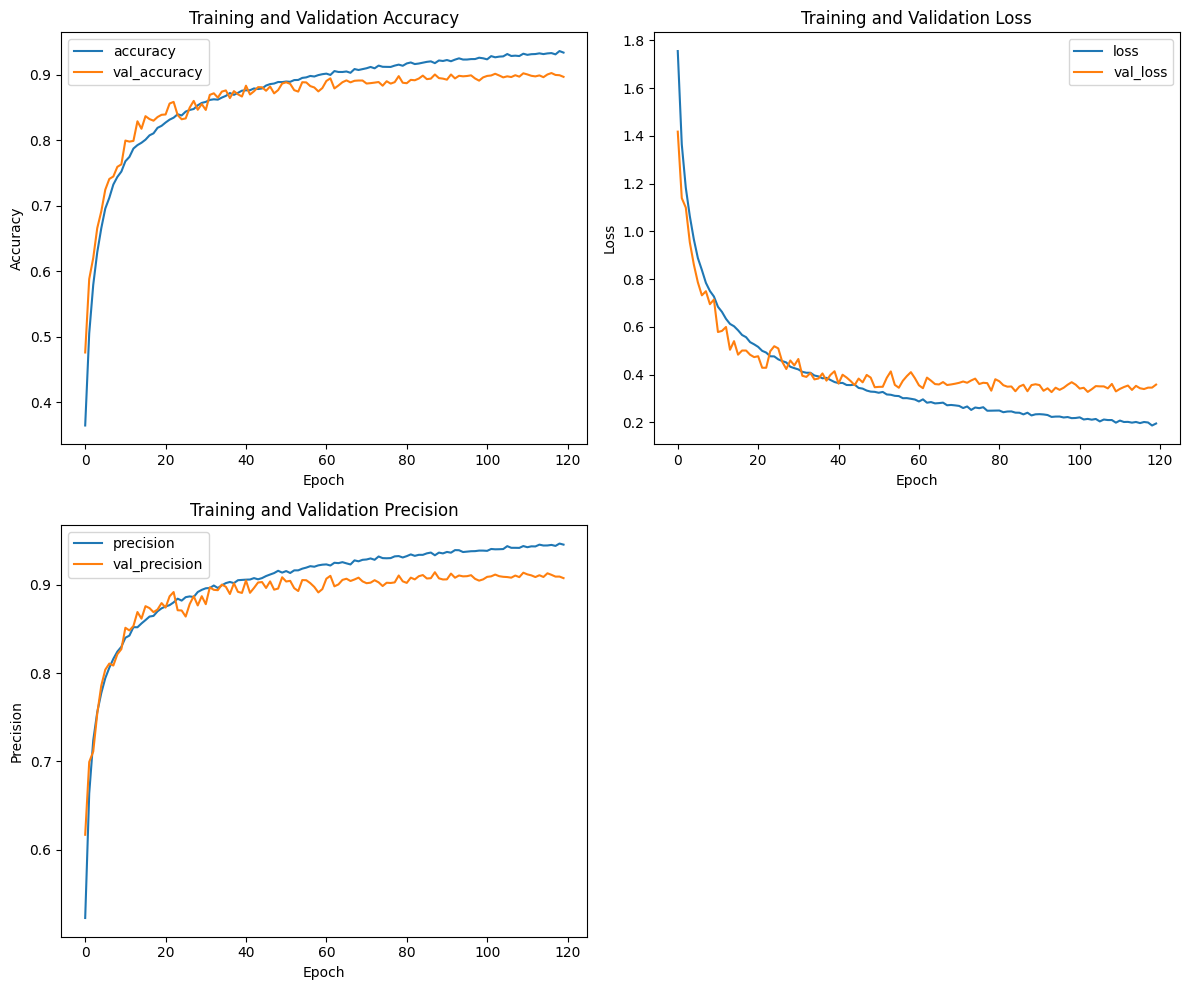

In [33]:
plot_accuracy_validation_precision(history_sgd)

#### Loading Saved Model

In [34]:
from keras.models import load_model
loaded_model = load_model(model_filename)

#### Calculating Predictions

In [35]:
y_pred = loaded_model.predict(X_test_normalized)
y_pred_argmax = y_pred.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


#### Confusion Matrix

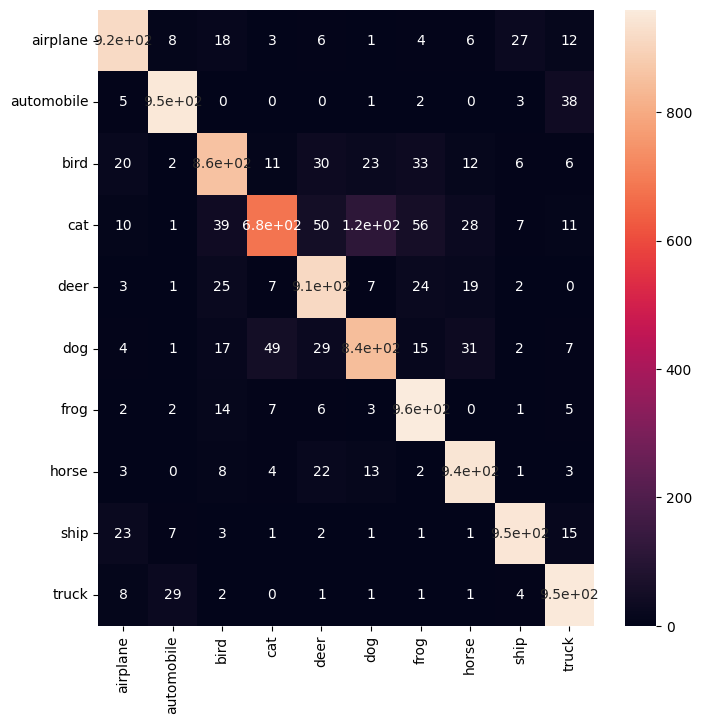

In [36]:
plot_confusion_matrix( label_names_list, y_test, y_pred_argmax)

#### ROC and AUC

ROC AUC Score: 0.9935120666666666


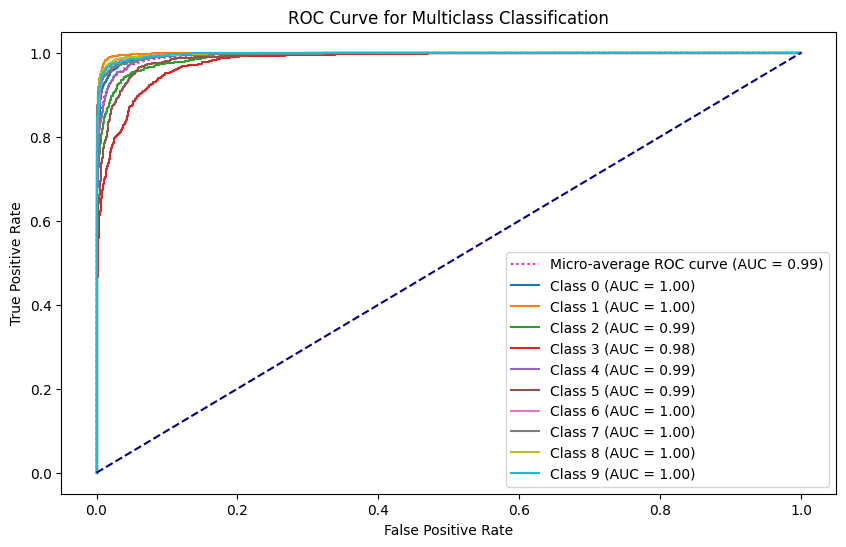

In [37]:
from sklearn.calibration import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

print("ROC AUC Score:", roc_auc)

from sklearn.calibration import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming y_test is not one-hot encoded
y_test_bin = label_binarize(y_test, classes=range(len(label_names_list)))  # Replace num_classes with the number of classes in your problem

y_pred_prob = y_pred

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_names_list)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])

# Compute micro-average ROC curve and ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')

# Plot ROC curve
plt.figure(figsize=(10, 6))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':')

# Plot each class's ROC curve
for i in range(len(label_names_list)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

#### Model Stats

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_argmax, target_names=label_names_list))

              precision    recall  f1-score   support

    airplane       0.92      0.92      0.92      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.87      0.86      0.86      1000
         cat       0.89      0.68      0.77      1000
        deer       0.86      0.91      0.89      1000
         dog       0.84      0.84      0.84      1000
        frog       0.87      0.96      0.92      1000
       horse       0.91      0.94      0.92      1000
        ship       0.95      0.95      0.95      1000
       truck       0.91      0.95      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.89     10000
weighted avg       0.90      0.90      0.89     10000



# Model Predictions

In [39]:
def make_prediction(image, label, model):
    
    image_to_predict = np.expand_dims(image, axis=0)  # Add batch dimension
    predictions = model.predict(image_to_predict)
    predicted_class = np.argmax(predictions)
    
    plt.imshow(image)

    print_green(f"\nActual Label Was: {label_names_list[label]} (class number {label})\n")
    if predicted_class == label:
        print_green(f"Model Predicted Label is: {label_names_list[predicted_class]} (class number {predicted_class}\n")
    else:
        print_red(f"Model Predicted Label is: {label_names_list[predicted_class]} (class number {predicted_class})\n")
        

#### Single Image Prediction

Predicting image number 8587
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
 
Actual Label Was: horse (class number 7)

 Model Predicted Label is: horse (class number 7



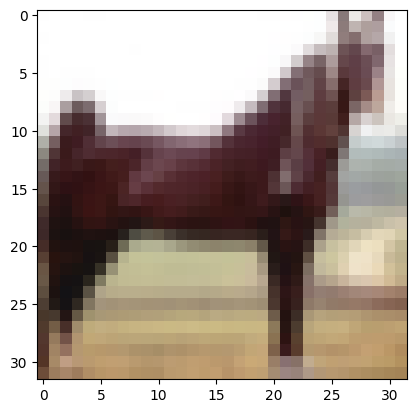

In [40]:
dataset_to_use = X_test_normalized
true_labels = y_test
index = random.randint(1, len(dataset_to_use))
print(f"Predicting image number {index}")
make_prediction(dataset_to_use[index],true_labels[index], loaded_model)

#### Random Image Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


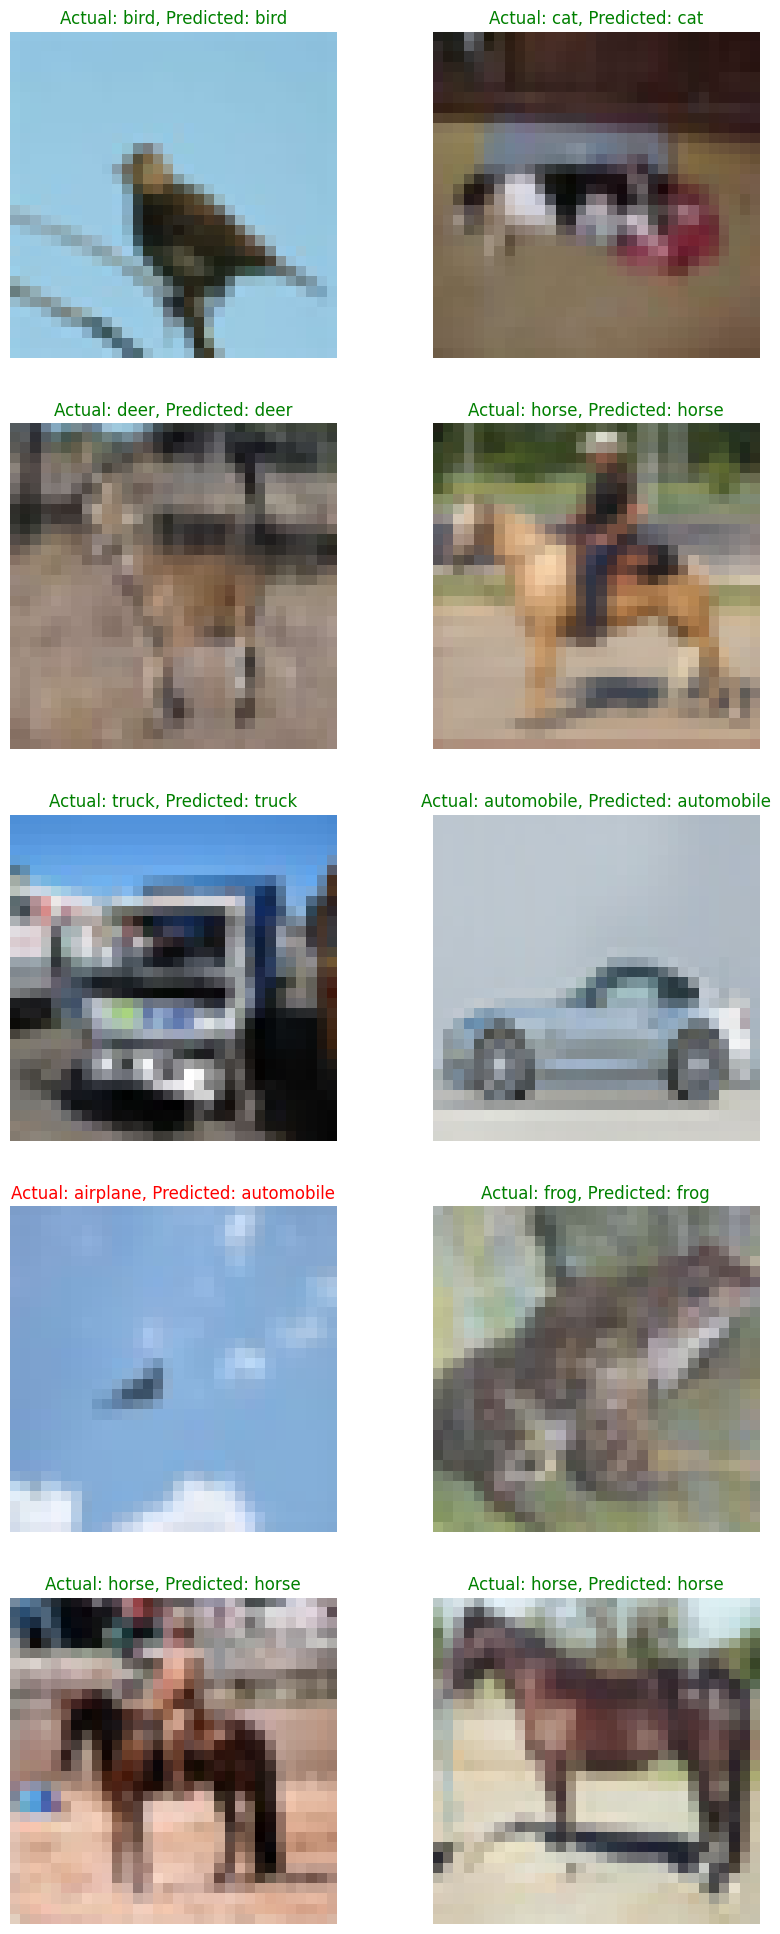

In [41]:
import random
import matplotlib.pyplot as plt
import numpy as np

def make_prediction_subplot(image, label, model, subplot_index, num_of_samples):
    image_to_predict = np.expand_dims(image, axis=0)
    predictions = model.predict(image_to_predict)
    predicted_class = np.argmax(predictions)

    plt.subplot(num_of_samples, 2, subplot_index)
    plt.imshow(image)
    plt.axis('off')

    if predicted_class == label:
        plt.title(f"Actual: {label_names_list[label]}, Predicted: {label_names_list[predicted_class]}", color='green')
    else:
        plt.title(f"Actual: {label_names_list[label]}, Predicted: {label_names_list[predicted_class]}", color='red')


num_of_samples = 10
rand_indices = random.sample(range(len(X_test_normalized)), num_of_samples)
plt.figure(figsize=(10, 5*num_of_samples))

for i, rand_idx in enumerate(rand_indices, 1):
    make_prediction_subplot(X_test_normalized[rand_idx], y_test[rand_idx], loaded_model, i, num_of_samples)

plt.show()
